## Setup

In [1]:
from imports import *
from constants import *
from functions import *

### Data Cleaning imports

In [2]:
from pprint import pprint
from bs4 import BeautifulSoup
import re
from nltk.tokenize import WordPunctTokenizer

## Data Cleaning

In [24]:
# Dataload
cols = ['sentiment','id','date','query_string','user','text']
df =  pd.read_csv("./data/" + DATASET,header=None, names=cols, encoding="ISO-8859-1")
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [25]:
# Sanity check
df['pre_clean_len'] = [len(t) for t in df.text]
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 4:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}
pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 4:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


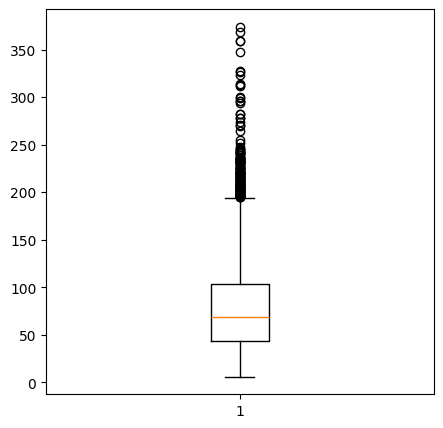

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141


In [26]:
fig, ax = plt.subplots(figsize=(5,5))
plt.boxplot(df.pre_clean_len)
plt.show()
df[df.pre_clean_len > 140].head(10)

## Tweets have at most 140 characters, but there are some registers with way more. We can see that there is a problem with the encoding

In [27]:
# HTML decoding
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [28]:
# Mentions
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [8]:
# URLs
df.text[0]
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [29]:
# Byte Order Mark (BOM)
testing = df.text[226]
print(testing)
testing.replace("ï¿½", "?")

Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers 


'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [30]:
# Hashtags
df.text[175]
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

In [31]:
# Cleaner
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.replace("ï¿½", "?")
    except:
        bom_removed = souped

    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()
testing = df.text[:100]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

/tmp/ipykernel_8941/153555506.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


['awww that bummer you shoulda got david carr of third day to do it',
 'is upset that he can not update his facebook by texting it and might cry as result school today also blah',
 'dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it not behaving at all mad why am here because can not see you all over there',
 'not the whole crew',
 'need hug',
 'hey long time no see yes rains bit only bit lol fine thanks how you',
 'nope they did not have it',
 'que me muera',
 'spring break in plain city it snowing',
 'just re pierced my ears',
 'could not bear to watch it and thought the ua loss was embarrassing',
 'it it counts idk why did either you never talk to me anymore',
 'would ve been the first but did not have gun not really though zac snyder just doucheclown',
 'wish got to watch it with you miss you and how was the premiere',
 'hollis death scene will hurt me severely to watch on film wry is directors cut no

In [33]:
clean_df = df.copy()
clean_df.rename(columns={"sentiment":"target"},inplace=True)
clean_df['text'] = df.text.apply(tweet_cleaner)
saveDF(clean_df,CLEAN_DATASET)

/tmp/ipykernel_8941/153555506.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


In [34]:
## There are some cells with null values
clean_df = readCSV(CLEAN_DATASET)
clean_df[clean_df.isnull().any(axis=1)].head()

importando desde ./data/clean_tweet.csv


,target,text,pre_clean_len
208,0,NaN,10
249,0,NaN,12
282,0,NaN,21
398,0,NaN,14
430,0,NaN,10


In [35]:
df = pd.read_csv("./data/" + DATASET,header=None, encoding="ISO-8859-1")
df.iloc[clean_df[clean_df.isnull().any(axis=1)].index,:].head()
## They are all mentions with no words

,0,1,2,3,4,5
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
282,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,NO_QUERY,__Susan__,@ITS_NEMESIS -------
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm


In [36]:
clean_df.dropna(inplace=True)
clean_df.reset_index(drop=True,inplace=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   target         1596041 non-null  int64 
 1   text           1596041 non-null  object
 2   pre_clean_len  1596041 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 36.5+ MB


In [37]:
## Overwrite the previous csv
clean_df['target'] = clean_df['target'].replace(4,1)
saveDF(clean_df,CLEAN_DATASET)